In [18]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from math import isclose
from scipy.stats import mannwhitneyu, median_abs_deviation, kstest



In [4]:
# read in the NWB file
#f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/000253/assets/89fa5067-31a8-4f2d-a043-5721120501a0/nwb.lindi.json")
#nwbfile = pynwb.NWBHDF5IO(file=f, mode='r').read()

filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-621890_ses-1186358749_ogen.nwb'
nwbfile = pynwb.NWBHDF5IO(filename, mode='r').read()

In [5]:
# load the units dataframe
units = nwbfile.units

In [23]:
# get stimulus times
stim_table = nwbfile.processing["optotagging"]["optogenetic_stimulation"]
stim_df = stim_table.to_dataframe()
stim_df


,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,6781.99807,Each pulse is 10 ms wide,0.77,6782.99807,5 hz pulse train,1.0,[optical_stimulation],"[(0, 1, optotagging pynwb.ogen.OptogeneticSeri..."
1,6783.95800,Each pulse is 6 ms wide,0.77,6784.95800,40 hz pulse train,1.0,[optical_stimulation],"[(1, 1, optotagging pynwb.ogen.OptogeneticSeri..."
2,6785.72773,Each pulse is 10 ms wide,0.97,6786.72773,5 hz pulse train,1.0,[optical_stimulation],"[(2, 1, optotagging pynwb.ogen.OptogeneticSeri..."
3,6787.64760,Each pulse is 6 ms wide,0.77,6788.64760,40 hz pulse train,1.0,[optical_stimulation],"[(3, 1, optotagging pynwb.ogen.OptogeneticSeri..."
4,6789.73925,half-period of a cosine wave,1.35,6790.73925,raised_cosine,1.0,[optical_stimulation],"[(4, 1, optotagging pynwb.ogen.OptogeneticSeri..."
...,...,...,...,...,...,...,...,...
445,7644.63792,half-period of a cosine wave,0.77,7645.63792,raised_cosine,1.0,[optical_stimulation],"[(445, 1, optotagging pynwb.ogen.OptogeneticSe..."
446,7646.50639,half-period of a cosine wave,0.97,7647.50639,raised_cosine,1.0,[optical_stimulation],"[(446, 1, optotagging pynwb.ogen.OptogeneticSe..."
447,7648.31652,Each pulse is 6 ms wide,0.77,7649.31652,40 hz pulse train,1.0,[optical_stimulation],"[(447, 1, optotagging pynwb.ogen.OptogeneticSe..."


In [25]:
stim_df.condition.unique()


array(['Each pulse is 10 ms wide', 'Each pulse is 6 ms wide',
       'half-period of a cosine wave'], dtype=object)

In [ ]:
stim_times = stim_df['start_time'][stim_df['condition'] == 'Each pulse is 10 ms wide'].to_numpy()
stim_times

array([6781.99807, 6785.72773, 6799.6413 , 6804.98369, 6808.82346,
       6827.4711 , 6831.54293, 6836.84523, 6842.499  , 6852.37403,
       6854.52381, 6858.14354, 6862.08365, 6871.99448, 6884.06543,
       6885.94556, 6887.68587, 6889.62598, 6899.45662, 6912.94714,
       6920.22022, 6922.39024, 6924.24066, 6928.4711 , 6930.25335,
       6964.81493, 6968.54502, 6990.03567, 6991.88135, 6994.02905,
       6998.09983, 7002.16265, 7004.34312, 7007.94465, 7015.72785,
       7017.41811, 7019.59817, 7023.38683, 7029.42959, 7031.4715 ,
       7035.46325, 7037.37338, 7043.46436, 7045.24419, 7055.07385,
       7065.06874, 7069.24838, 7071.36089, 7075.15242, 7082.8756 ,
       7084.67552, 7086.60498, 7088.58482, 7094.45672, 7096.18841,
       7098.33838, 7100.37959, 7102.12992, 7103.85032, 7109.58268,
       7113.27538, 7119.23723, 7127.17081, 7131.06281, 7133.07291,
       7136.47405, 7140.45605, 7148.79435, 7158.10762, 7160.19964,
       7168.17194, 7170.29018, 7181.72166, 7186.03172, 7191.68

In [27]:
# period to exclude from analysis before and after the stimulus event 
stim_duration = 0.01  # 10 ms
censor_period = 0.002

# bin size for counting spikes
time_resolution = 0.001

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_start_time to 0-censor_period
window_start_time = -0.01
window_end_time = 0.025

def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in tqdm(range(len(units_spike_times))):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

In [28]:
def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # time bins used
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
    stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=1)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

In [ ]:
units

In [29]:
spike_times = nwbfile.units['spike_times']
spike_counts, spike_matrix, bin_edges, bl_start, bl_end, stim_start, stim_end = get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)


100%|██████████| 2446/2446 [00:01<00:00, 2401.25it/s]


In [30]:
def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10)) # change fig size for different plot dimensions
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

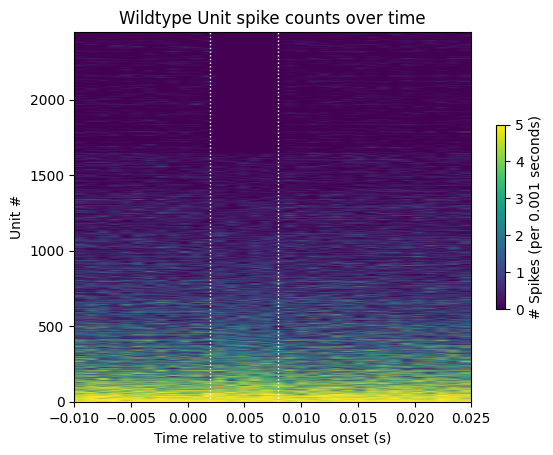

In [31]:
fig, axes = plt.subplots(1,1)

unit_response_means = np.mean(spike_counts[:, stim_start:stim_end], axis=1)
sorted_respons_idxs = np.argsort(unit_response_means)
sorted_sst_spike_counts = np.take(spike_counts, sorted_respons_idxs, axis=0)

show_counts(sorted_sst_spike_counts,
            bin_edges,
            figax = (fig, axes),
            stim_bounds=[censor_period, stim_duration-censor_period],
            title="Wildtype Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

In [33]:
# calculate cell type metrics
# utility function used by first_spike_latencies_and_jitters and ks_salt
# returns an array of length 'start_times' with the first spike time after each `start_time` (and the censor period)
def get_first_spikes_after_onset(spike_times, start_times):
    response_start_times = start_times[start_times < spike_times.max()]

    first_spike_idxs = np.searchsorted(spike_times, response_start_times)
    first_spike_times = spike_times[first_spike_idxs] - response_start_times
    first_spike_times += censor_period
    
    return first_spike_times


def first_spike_latencies_and_jitters(spike_times, start_times):
    first_spike_times = get_first_spikes_after_onset(spike_times, start_times)
    
    first_spike_jitter = median_abs_deviation(first_spike_times)
    first_spike_latency = np.median(first_spike_times)
    
    return first_spike_jitter, first_spike_latency


def ks_salt(spike_times, start_times):
    first_spikes = get_first_spikes_after_onset(spike_times, start_times)
 
    # get first spikes at some time sufficiently prior the stimulus times so as to be a baseline period
    # but not too far back, for risk of sampling time during a previous stimulus event
    baseline_spikes = get_first_spikes_after_onset(spike_times, start_times-0.01)
    
    try:
        return kstest(first_spikes, baseline_spikes)[1]
    except:
        return np.nan
    
def fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx):
    bl_mean_count = np.mean(bl_trial_counts)
    
    bins_pvals = []
    bins_above_baseline = []
    
    for bin_idx in range(stim_start_idx, stim_end_idx):
        time_bin = spike_matrix[unit_idx, :, bin_idx]
        bins_pvals.append(mannwhitneyu(bl_trial_counts, time_bin)[1])
        bins_above_baseline.append(np.mean(time_bin) > bl_mean_count)

    num_sig_bins = np.sum( (np.array(bins_pvals)<0.01) & np.array(bins_above_baseline) )
    fraction_sig_bins = num_sig_bins / (stim_end_idx-stim_start_idx)
    return fraction_sig_bins


def fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials):
    bl_mean_count = np.mean(bl_trial_counts)
    
    trials_pvals = []
    trials_above_baseline = []
    
    for trial_idx in range(n_trials):
        trial = spike_matrix[unit_idx, trial_idx, stim_start_idx:stim_end_idx]
        trials_pvals.append(mannwhitneyu(bl_trial_counts, trial)[1])
        trials_above_baseline.append(np.mean(trial) > bl_mean_count)

    num_sig_trials = np.sum( (np.array(trials_pvals)<0.01) & np.array(trials_above_baseline) )
    fraction_sig_trials = num_sig_trials / n_trials
    return fraction_sig_trials

def get_opto_metrics(stim_times, units_spike_times, spike_counts, spike_matrix, censor_period, stim_start_idx, stim_end_idx, bl_start_idx, bl_end_idx):
    n_units = len(units_spike_times)
    n_trials = len(stim_times)
    start_times = np.array(stim_times) + censor_period

    # get mean response spike rate for each unit
    avg_spikes = spike_counts[:,stim_start_idx:stim_end_idx] / n_trials
    mean_response_spike_rates = np.mean(avg_spikes, axis=1)

    # these will be populated for each unit
    first_spike_jitters = np.zeros((n_units))
    first_spike_latencies = np.zeros((n_units))
    fracs_time_responsive = np.zeros((n_units))
    fracs_trials_responsive = np.zeros((n_units))
    salts = np.zeros((n_units))

    # populate each optotagging metric array for each unit
    for unit_idx in range(n_units):
        spike_times = units_spike_times[unit_idx]

        first_spike_jitter, first_spike_latency = first_spike_latencies_and_jitters(spike_times, start_times)

        first_spike_jitters[unit_idx] = first_spike_jitter
        first_spike_latencies[unit_idx] = first_spike_latency
        salts[unit_idx] = ks_salt(spike_times, start_times)

        # use the mean baseline spike counts for each trial to determine when the unit is 'responsive'
        bl_trial_counts = np.mean(spike_matrix[unit_idx, :, bl_start_idx:bl_end_idx], axis=0)
        fracs_time_responsive[unit_idx] = fraction_time_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx)
        fracs_trials_responsive[unit_idx] = fraction_trials_responsive(unit_idx, spike_matrix, bl_trial_counts, stim_start_idx, stim_end_idx, n_trials)

    return mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts

In [34]:
opto_metrics = get_opto_metrics(stim_times, spike_times, spike_counts, spike_matrix, censor_period, stim_start, stim_end, bl_start, bl_end)
mean_response_spike_rates, first_spike_jitters, first_spike_latencies, fracs_time_responsive, fracs_trials_responsive, salts = opto_metrics

df = pd.DataFrame({"mean response spike rate": mean_response_spike_rates,
                   "first spike jitter": first_spike_jitters,
                   "first spike latency": first_spike_latencies,
                   "fraction time responsive": fracs_time_responsive,
                   "fraction trials responsive": fracs_trials_responsive,
                   "ks salt value": salts
                  })
df

/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return hypotest_fun_in(*args, **kwds)
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/50/_vs4yj0n27jbxcv71kvzktqr0000gp/T/ipykernel_22210/1695935706.py:31: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return kstest(first_spikes, baseline_spikes)[1]


,mean response spike rate,first spike jitter,first spike latency,fraction time responsive,fraction trials responsive,ks salt value
0,0.001111,0.239881,0.345798,0.166667,0.0,0.996947
1,0.043333,0.014357,0.019625,0.500000,0.0,0.532187
2,0.002222,1.493067,1.576594,0.333333,0.0,0.996947
3,0.031111,0.019241,0.028424,0.833333,0.0,0.724957
4,0.000000,1.199191,1.312309,0.000000,0.0,1.000000
...,...,...,...,...,...,...
2441,0.001111,1.343687,1.723517,0.166667,0.0,1.000000
2442,0.000000,30.001664,37.279204,0.000000,0.0,1.000000
2443,0.000000,7.176218,9.375034,0.000000,0.0,1.000000
2444,0.005556,0.448196,0.603614,0.666667,0.0,1.000000


In [61]:
peak_channels = units.to_dataframe()['peak_channel_id']
electrodes_df = nwbfile.electrodes.to_dataframe()
brain_areas = electrodes_df.loc[peak_channels]['location']



Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383],
      dtype='int64', name='id', length=2304)